In [2]:
%load_ext autoreload
%autoreload 2

# General imports

# Generally necessary toos for numerics and plotting.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc({
    'font': {
        'family' : 'Helvetica', 
        'size': 9
    }
})


# Loading bars
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from utils import *

# Hierarchy Decomposition

## Developing Brain Atlas

The developing brain atlas published in [Thompson (2014)](https://doi.org/10.1016/j.neuron.2014.05.033).  Using the provided [api](https://help.brain-map.org/display/devmouse/API) we developed an interface to download,  handle, and analyse the complete expression data as a voxelated grid.  The `abianalysis` package contains this interface.

## Pre-processing

The data is pre-processed identically before all analyses.  The source data contains an expression value of -1 for every invalid measurement.  Firstly, all genes with more than 20% such invalid values across all voxels at one time-point were discarded.  Secondly, all voxels with more than 20% invalid values were discarded. Thirdly, the expression of each gene is independently centered to have a mean of zero and rescaled to have a unit variance (and hence also standard deviation).  

The gene expression values were scaled so they each have equal contribution to the total variance.  We consider such rescaling justified, because it is plausible biologically that the ratio of transcripts in a voxel relative to other voxels is a better indicator of functional impact than the absolute number of transcripts.

Only genes that were included in all volumes after independent pre-processing were used in the analysis, even of the individual volumes.  The included genes are listed in the interactive table below.

In [3]:
volume = load_volume('E18.5')
gene_viewer(volume)

## Decomposition Algorithm

An iteration of the hierarchical decomposition begins with the selection of a subset of voxels (the initial selection is the set of all voxels).  The gene expression of a selection of voxels can be expressed as a matrix $X$, where each row corresponds to a voxel and each column to a gene (so $X_{ij}$ is expression of the $j$th gene in the $i$th voxel.

The main axis of covariance coincides with the first [principal component](https://en.wikipedia.org/wiki/Principal_component_analysis).  To determine the main axis of covariance we used the `PCA` routine from the `scikit-learn` python package [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  This routine calculates principal components by subtracting the mean from the data $X^{\text{centered}}_{ij} = X_{ij} - \sum_{i=1}^n X_{ij} / n$, where $n$ is the number of voxels; and then finding the [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) $U \Sigma V^T = X^{\text{centered}}$, where $U,V$ are unitary matrices, and $\Sigma$ is a diagonal matrix with descending diagonal entries, named singular values.  The first column $V_1$ of $V$ (so the first row of $V^T$) corresponds to the main direction of covariance.

Projecting the centered voxels onto the first principal component $X^{\text{centered}}V_1$ yields per voxel a single-value summary value of the voxel's expression:  If the summary value is positive/negative, the voxel's expression correlates positively/negatively with the main direction of covariance.  

We assume that the differential expression between two mitotic siblings correlates strongly with the main axis of covariance over the progeny (see Rationale).  So, each voxel is sorted into either progeny by the sign of their correlation with the covariance across the voxels.

This process is repeated recursively on each of the progenies, until each split contains only a single voxel.

## Results

In [4]:
from abianalysis.volume import AGES
from abianalysis.hierarchy.matching import rotate_to_match

from utils import load_hierarchy

print('Loading hierarchies...')
hierarchies = [load_hierarchy(age) for age in AGES]

print('Rotating hierarchies to match...')
for h1, h2 in zip(hierarchies, hierarchies[1:]):
    rotate_to_match(h1, h2)
print('Done.')

Loading hierarchies...
Rotating hierarchies to match...
Done.


In [5]:
shuffled_hierarchies = [load_hierarchy(age, shuffled=True) 
                        for age in AGES]

8it [01:04,  8.09s/it]


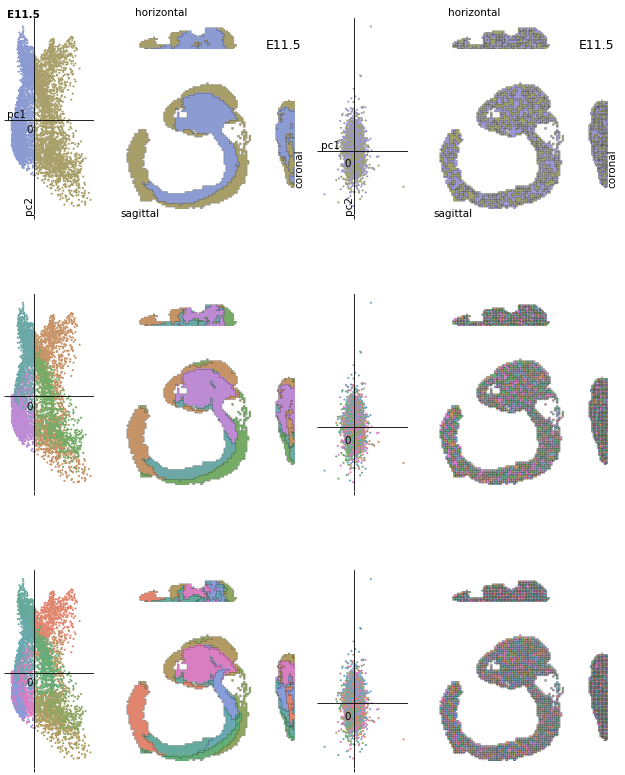

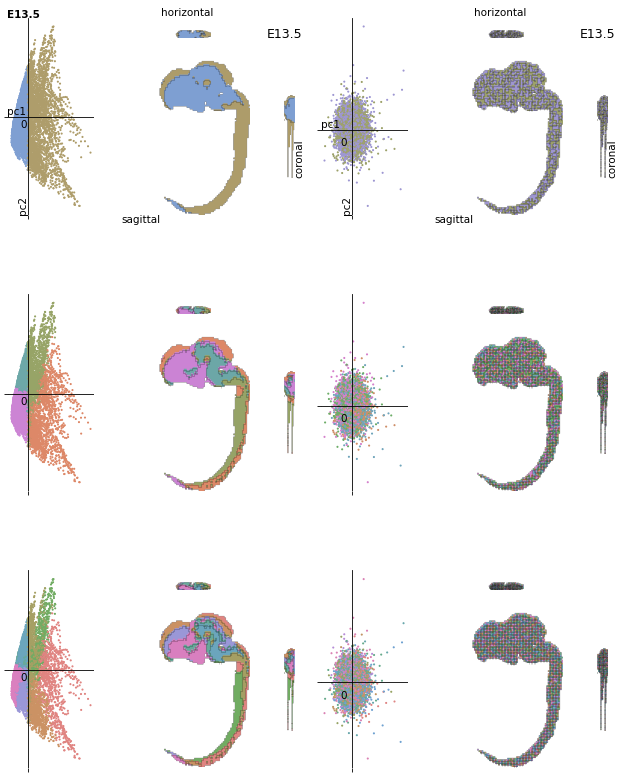

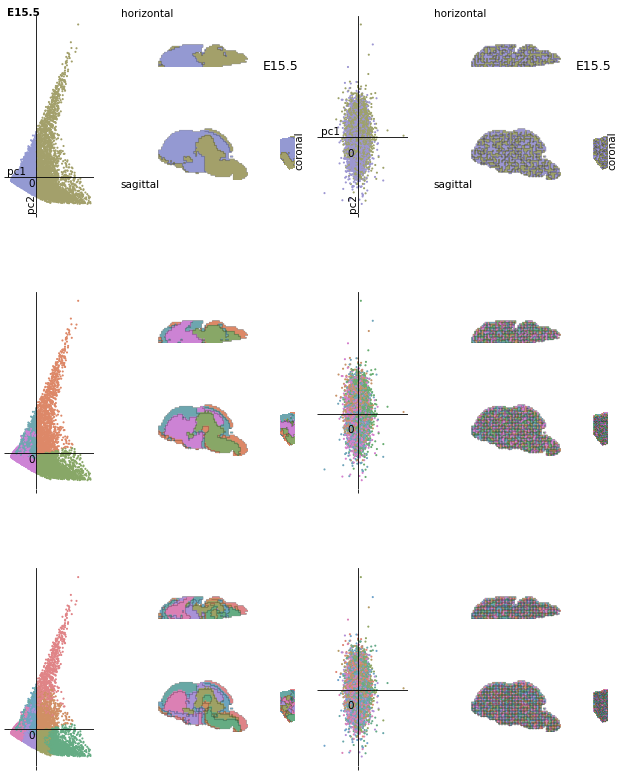

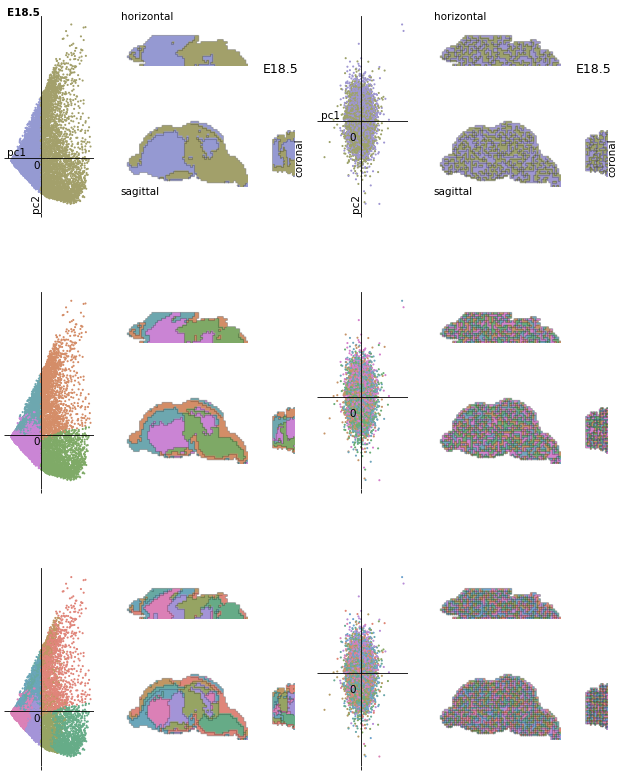

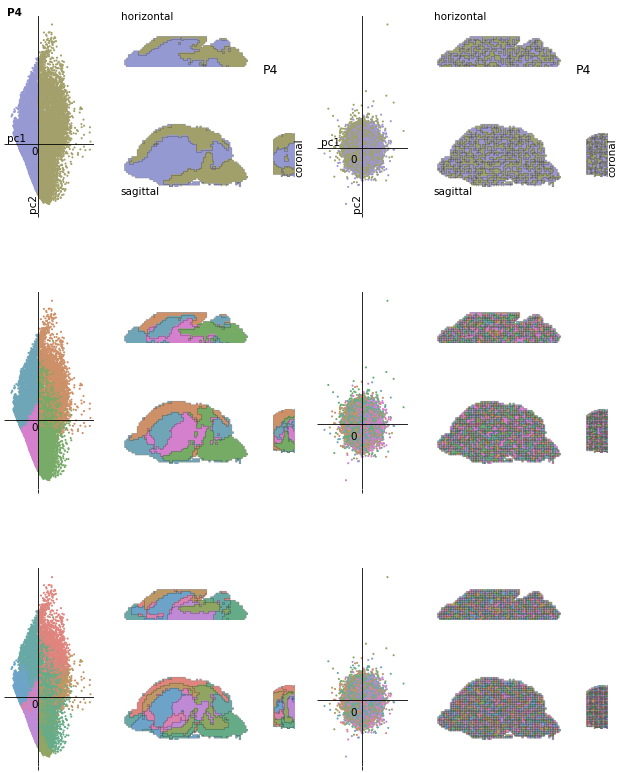

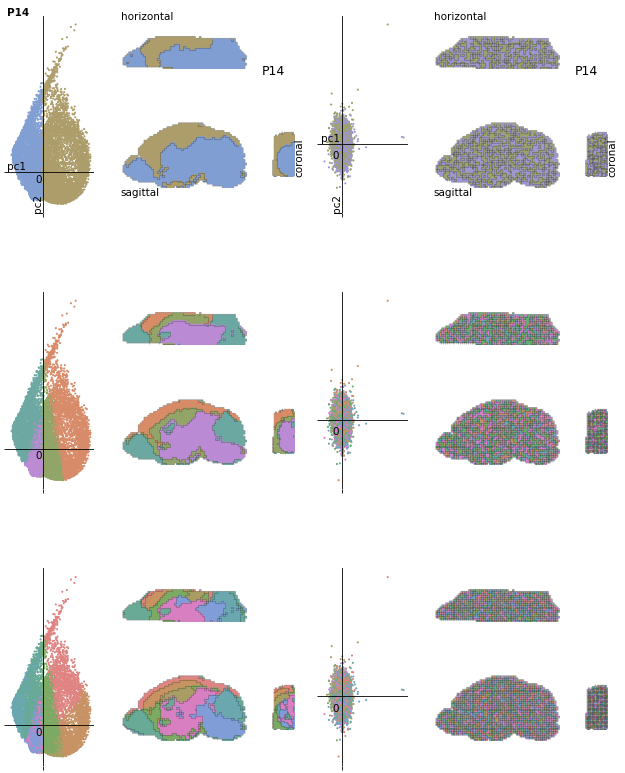

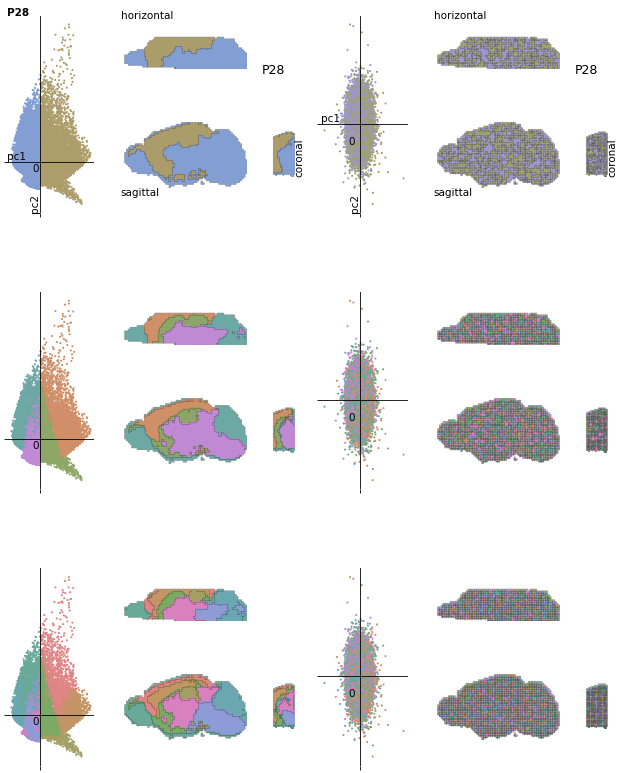

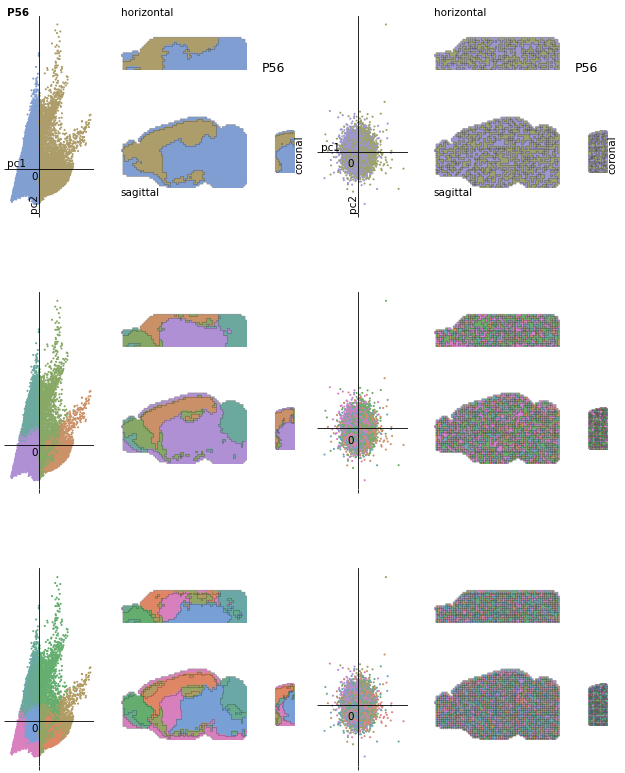

In [6]:
# Making plots.
for hierarchy, sh in tqdm(zip(hierarchies, shuffled_hierarchies)):
    fig = make_plot(hierarchy, sh, 3)
    fig.savefig(f'hierarchy_{hierarchy.volume.age}.pdf',
                bbox_inches='tight', pad_inches=.25, dpi=300,
                transparent=True)

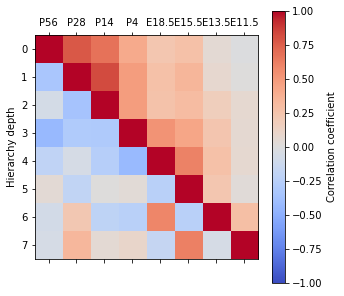

In [8]:
from itertools import islice
from scipy.spatial.distance import squareform, cdist


def get_components(hs):
    return np.vstack([r.component for r in hs])

def get_determination(x1, x2):
    return (1 - cdist(x1, x2, metric='correlation'))

def component_determination(hs):
    c = get_components(hs)
    return get_determination(c, c)

def control_determination(hs):
    c = get_components(hs)
    return get_determination(c, np.random.normal(size=c.shape))


def left_branch(h):
    yield h
    while len(h.children) > 0:
        h = h.children[0]
        yield h
        

n = len(hierarchies)
im = np.zeros((n,n))
for i in range(n):
    targets = hierarchies[::-1][i:]
    top = component_determination(targets)
    bottom = component_determination(islice(left_branch(targets[0]), len(targets)))
    im[i,i:] = top[0, :]
    im[i:,i] = bottom[:, 0]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
cbar = fig.colorbar(ax.matshow(im,cmap='coolwarm', vmin=-1, vmax=1))
cbar.set_label('Correlation coefficient')
ax.set_xticks(range(len(AGES)))
ax.set_xticklabels(AGES[::-1])
ax.grid(False)
ax.set_ylabel('Hierarchy depth')
fig.savefig('orthogonality.pdf', 
            transparent=True, dpi=300)

8it [00:34,  4.36s/it]


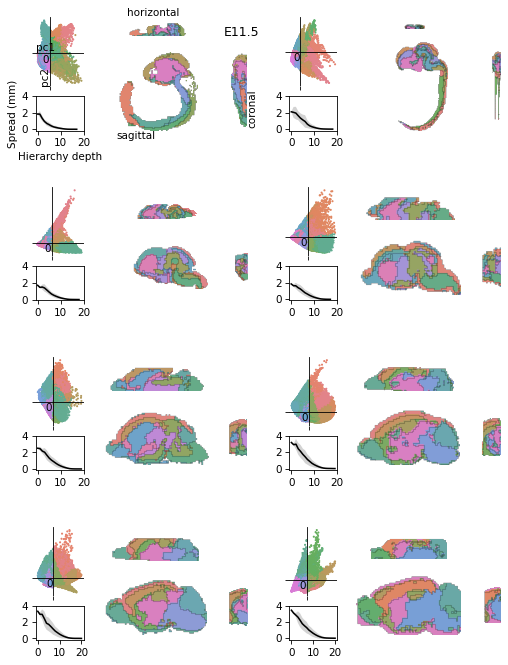

In [9]:
from matplotlib.gridspec import GridSpecFromSubplotSpec

def make_single_plot(hierarchies, depth):
    fig = plt.figure(dpi=75, figsize=(8,11))
    g = GridSpec(nrows=4, ncols=2, hspace=.5, wspace=.2)
    
    for i, hierarchy in tqdm(enumerate(hierarchies)):
        helper = HierarchyPlotter(hierarchy)
        size = helper.image_size
        gs = GridSpecFromSubplotSpec(
            subplot_spec=g[i // 2, i % 2],
            nrows=2, ncols=2,
            width_ratios=[1, 3],
            height_ratios=[2, 1], wspace=.2,
        )

        ax = fig.add_subplot(gs[0, 0])
        helper.plot_expression(ax, depth + 1, show_labels=i==0)
        
        helper.plot_views(fig, gs[:, 1], depth, show_labels=i==0)

        ax = fig.add_subplot(gs[1, 0])
        plot_region_sizes(ax, hierarchy)
        if i == 0:
            ax.set_ylabel('Spread (mm)')
            ax.set_xlabel('Hierarchy depth')
        ax.set_xticks([0, 10, 20])
        ax.set_yticks([0, 2, 4])
    return fig

make_single_plot(hierarchies, 3)\
    .savefig(f'hierarchy_all_times.pdf', 
             dpi=300, pad_inches=.25, transparent=True)

In [10]:
%%time
depth_vs_spread_per_age = {
    h.volume.age: get_depth_vs_spatial_spread(h) 
    for h in tqdm(hierarchies)
}

100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.55s/it]

CPU times: user 9.8 s, sys: 2.34 s, total: 12.1 s
Wall time: 12.4 s


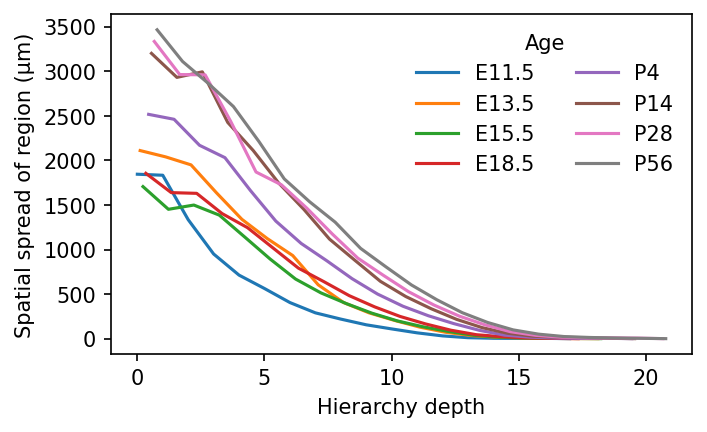

In [11]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

n = len(AGES)
for i, age in enumerate(AGES[:n]):
    depths, region_sizes = zip(*depth_vs_spread_per_age[age].items())
    ax.plot(
        i / (n + 1) + np.array(depths),
        [np.mean(r) for r in region_sizes],
        label=age,
    )
ax.set_ylabel('Spatial spread of region (µm)')
ax.set_xlabel('Hierarchy depth')
ax.legend(framealpha=1, edgecolor='white', title='Age', ncol=2)

fig.savefig('hierarchy_spatial_spread.pdf', dpi=300, transparent=True)